<a href="https://colab.research.google.com/github/sonichandni/pass-fail-prediction-model-TF2/blob/master/pass_fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [90]:
!wget https://raw.githubusercontent.com/sonichandni/pass-fail-prediction-model-TF2/master/StudentsPerformance.csv

--2020-03-02 07:38:36--  https://raw.githubusercontent.com/sonichandni/pass-fail-prediction-model-TF2/master/StudentsPerformance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5018 (4.9K) [text/plain]
Saving to: ‘StudentsPerformance.csv.1’

StudentsPerformance 100%[===================>]   4.90K  --.-KB/s    in 0s      

2020-03-02 07:38:36 (87.5 MB/s) - ‘StudentsPerformance.csv.1’ saved [5018/5018]



In [0]:
df = pd.read_csv("StudentsPerformance.csv")

In [92]:
df.head()

,score,target
0,72,1
1,69,1
2,90,1
3,47,1
4,76,1


In [93]:
df.describe()

,score,target
count,1000.00000,1000.000000
mean,66.08900,0.960000
std,15.16308,0.196057
min,0.00000,0.000000
25%,57.00000,1.000000
50%,66.00000,1.000000
75%,77.00000,1.000000
max,100.00000,1.000000


In [0]:
# df.drop(['lunch', 'test preparation course', 'reading score','writing score'])
# del df['Unnamed: 0']
# df.columns
# df['target'] = np.where(df['math score']>=40, 1, 0)
# df.columns = ['score', 'target']
# df.to_csv('StudentsPerformance.csv', index=False)
# import matplotlib.pyplot as plt

# df.plot(kind='hist', title='Normally distributed random values') # hist computes distribution
# plt.show()

In [95]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

640 train examples
160 validation examples
200 test examples


In [0]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(df, shuffle=True, batch_size=32):
  df = df.copy()
  labels = df.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  return ds

In [0]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [98]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of marks:', feature_batch['score'])
  print('A batch of targets:', label_batch )

Every feature: ['score']
A batch of marks: tf.Tensor(
[93 70 84 36 98 57 45 54 38 65 81 57 62 80 54 86 71 78 76 61 83 69 85 53
 97 59 69 74 73 62 65 68], shape=(32,), dtype=int32)
A batch of targets: tf.Tensor([1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int32)


In [0]:
example_batch = next(iter(train_ds))[0]

In [0]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [0]:
# score = feature_column.numeric_column("score")
# demo(score)

In [0]:
# score_buckets = feature_column.bucketized_column(score, boundaries=[40,100])
# demo(score_buckets)

In [0]:
feature_columns = []
for header in ['score']:
  feature_columns.append(feature_column.numeric_column(header))

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [0]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=100)

In [0]:
def plot_metrics(history):
  metrics =  ['loss']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

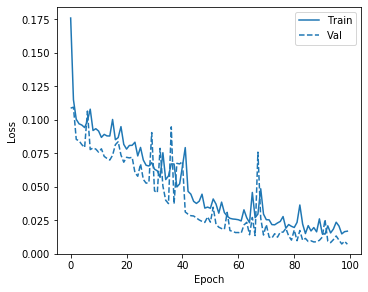

In [107]:
import matplotlib as mpl

import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(history)


In [108]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

7/7 [==============================] - 0s 3ms/step - loss: 0.0285 - accuracy: 0.9850
Accuracy 0.985


In [109]:
predict = model.predict_classes([40])
class_val = predict[0][0]
if class_val == 0:
  print("you are fail")
else:
  print("you are pass")

you are pass


In [110]:
predict = model.predict_classes([9])
class_val = predict[0][0]
if class_val == 0:
  print("you are fail")
else:
  print("you are pass")

you are fail


In [123]:
predict = model.predict_classes([38])
class_val = predict[0][0]
if class_val == 0:
  print("you are fail")
else:
  print("you are pass")

you are fail


In [119]:
predict = model.predict_classes([39])
class_val = predict[0][0]
if class_val == 0:
  print("you are fail")
else:
  print("you are pass")

you are pass
